# Analyse de données de films

Nous proposons de travailler sur des données décrivant des films. Les possibilités sont larges et vous êtes évalués sur vos propositions et votre méthodologie plus que sur vos résultats.

Les données de départ sont disponibles sur:
https://grouplens.org/datasets/movielens/
au format CSV. 

Nous nous intéresserons en particulier au jeu de données: **MovieLens 20M Dataset**. Dans ce jeu de données, vous disposez entre autre de:
* Idendifiant du film dans IMdb et TMdb (ça sera important ensuite)
* Catégorie(s) du film
* Titre du film
* Notes données par les internautes aux films

Afin de rendre le projet plus intéressant, nous ajoutons des données sur les acteurs et producteurs associés aux films (récupéré sur TMdb). Ces données sont disponibles sur les liens suivants:

http://webia.lip6.fr/~guigue/film_v2.pkl <br>
http://webia.lip6.fr/~guigue/act_v2.pkl <br>
http://webia.lip6.fr/~guigue/crew_v2.pkl

Ces fichiers contiennent respectivement : une nouvelle description des films (dont l'identifiant TMdb et la note moyenne donnée par les internautes, la date de sortie,...), une description des acteurs de chaque film et une description des équipes (scénariste, producteur, metteur en scène) pour chaque film.

Ces données sont des listes de taille 26908, chaque élément de la liste correspondant à un dictionnaire dont vous étudierez les clés pour récupérer les informations utiles.

**ATTENTION** Les contraintes de récupération d'informations en ligne font que la base MovieLens compte 27278 films mais les fichiers ci-dessus n'en comptent que 26908. Le plus simple est probablement d'éliminer les films de MovieLens qui ne sont pas dans cette seconde base.

## Consignes générales pour l'analyse des données

Vous devez proposer plusieurs analyses des données, qui devront à minima utiliser les
 techniques suivantes:
 
1. Mettre en forme les données pour identifier les acteurs et les catégories, les indexer
1. Traiter au moins un problème de régression supervisé (par exemple la prédiction de la note moyenne donnée à un film par les internautes).
1. Traiter au moins un problème de classification supervisé (par exemple la prédiction de la catégorie d'un film)
1. Utiliser les données catégorielles (catégories, acteurs,...) de manière discrète ET de manière coninue (*dummy coding*) dans des approches différentes
1. Proposer au moins une approche de catégorisation non supervisée (pour regrouper les acteurs par exemple)
1. Mener une campagne d'expérience permettant de comparer les performances sur un problème en fonction des valeurs d'un paramètre (et donc, in fine, trouver la meilleure valeur du paramètre)
1. Proposer quelques illustrations

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import random
%matplotlib inline
import pickle as pkl
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('..')

# Importation de la librairie iads
import iads as iads

import sklearn

# importation de LabeledSet
from iads import LabeledSet as ls

# importation de Classifiers
from iads import Classifiers as cl

#importation de la fonction de kernel trick
from iads import KernelPolynomial as kerpoly

#importation de kmoyenne
from iads import kmoyenne as km

## Chargement des données (base MovieLens + enrichissements)

In [2]:
# Chargement des données MovieLens
fname_links = os.path.abspath(r"C:\Users\Radoy\Documents\Projet3I026\3i026\ml-latest-small\movies.csv")
movies_set  = pd.read_csv(fname_links)
fname_links = os.path.abspath(r"C:\Users\Radoy\Documents\Projet3I026\3i026\ml-latest-small\ratings.csv")
ratings_set = pd.read_csv(fname_links)

In [3]:
# Chargement des données complémentaires
fname = os.path.abspath(r"C:\Users\Radoy\Documents\Projet3I026\3i026\ml-20m\act_v2.pkl")
acteurs_data = pkl.load(open(fname, "rb"))

fname = os.path.abspath(r"C:\Users\Radoy\Documents\Projet3I026\3i026\ml-20m\film_v2.pkl")
films_data = pkl.load(open(fname, "rb"))

fname = os.path.abspath(r"C:\Users\Radoy\Documents\Projet3I026\3i026\ml-20m\crew_v2.pkl")
crew_data = pkl.load(open(fname, "rb"))

## Feature engineering
A vous de créer les caractéristiques de description des données qui permettront d'améliorer les performances dans les tâches que vous aurez choisi d'aborder dans le projet.

In [4]:
# Faire un dictionnaire avec tous les acteurs (acteur => indice)
# + un dictionnaire inversé (indice => acteur)
actors = dict()
actors_inv = dict()
for lista in acteurs_data:
    for a in lista:
        # affecte une valeur à une clé si la clé n'est pas utilisée
        res = actors.setdefault(a['name'], a['gender'])
        if res == len(actors)-1:
            actors_inv[len(actors)-1] = a['name']

# Exemple de transformation supplémentaire
# Dans combien de films de base joue Tom Hanks? (Réponse 57)
# Dans combien de comédies...

# => On voit qu'il est possible de créer facilement des nouvelles caractéristiques qui
# apporteront des informations utiles pour certaines tâches

# Nous commencerons par faire une regression supervisé
Pour cela nous allons utiliser d'abord comme donnees d'etude les categories d'un film.

L'idee sera donc de pouvoir predire une note d'un film juste a partir de ses categories.

La prediction est pour nous reussite si la valeur predite appartient a l'intervalle 
[score-0.5;score+0.5]

In [5]:
#A partir de la base movies.csv nous creons un tableau de tous les genres
genres = set(movies_set["genres"])
categories = set()
for i in genres:
    for j in i.split("|"):
        categories.add(j)
categories = list(categories)
categories.sort()
categories

['(no genres listed)',
 'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western']

In [6]:
#Maintenant nous nous interessons aux scores moyens de chaque film 
ratings = ratings_set.sort_values("movieId")
ratings = ratings.groupby("movieId")["rating"].mean()
ratings.to_frame()

,rating
movieId,
1,3.920930
2,3.431818
3,3.259615
4,2.357143
5,3.071429
6,3.946078
7,3.185185
8,2.875000
9,3.125000


In [7]:
#Le score moyen etant donc notre label nous pouvons commencer par creer
#notre labeled set
movies_LabeledSet = ls.LabeledSet(20)
for indx,row in movies_set.iterrows():
    table = [0]*20
    if row["movieId"] in ratings.keys():
        for i in row["genres"].split("|"):
            table[categories.index(i)] = 1
        movies_LabeledSet.addExample(table,ratings.at[row["movieId"]])

In [8]:
#Notre labeled set est donce cree, 
#nous pouvons commencer par faire notre perceptron

kp = kerpoly.KernelPolynomial()
training,predict = ls.split(0.6,movies_LabeledSet)
perceptron_projet= cl.ClassifierMoindreCarres(len(kp.transform(training.getX(0))),0.005,kp)

Text(0, 0.5, 'Accuracy')

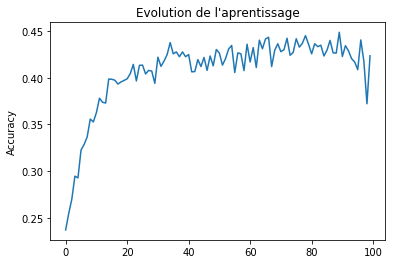

In [9]:
#Nous allons maintenant afficher comment evolue la precision
#de notre perceptron
accuracy = list()
for i in range(100):
    perceptron_projet.train(training,100)
    accuracy.append(perceptron_projet.accuracy(predict))

plt.plot([i for i in range(100)],accuracy)
plt.title('Evolution de l\'aprentissage')
plt.ylabel('Accuracy')

La precision etant deux fois meilleurs que l'aleatoire, puisque l'on a une chance sur 5 (puisque le score est sur 5 et que la marge d'erreur est d'un point), nous nous sommes dit que si l'on anjoute pour chaque film la meilleur note de ses acteurs et la pire, la precision augmentera.

In [10]:
#Nous avons donc cree deux dictionnaires
# le premier acteurs_dans_film qui donne une liste d'acteurs pour chaque film
#le second permet d'avoir tous les acteurs de l'etude
acteurs_dans_film = dict()
tous_les_acteurs = set()
for index,row in movies_set.iterrows():
    liste_acteurs = list()
    for i in acteurs_data[index]:
        liste_acteurs.append(i['name'])
        tous_les_acteurs.add(i['name'])
    acteurs_dans_film[row['title']] = [liste_acteurs,[films_data[index].get('vote_average')]]

In [11]:
#Nous avons ecrit une fonction qui permettra d'avoir la liste
#des cles d'un dictionnaire en fonction d'une valeur
def getKeysByValue(dictOfElements, valueToFind):
    listOfKeys = list()
    listOfItems = dictOfElements.items()
    for item  in listOfItems:
        if valueToFind in item[1][0] :
            listOfKeys.append(item[0])
    return  listOfKeys

In [12]:
#Maintenant il suffit de donner a chaque acteur sa note moyenne
#Elle se calcule donc depuis la note de chaque film ou l'acteur a joue
dict_acteurs_moy = dict()
for i in tous_les_acteurs:
    films = getKeysByValue(acteurs_dans_film,i)
    som = 0
    for j in films:
        som += acteurs_dans_film.get(j)[1][0]
    if len(films) == 0:
        dict_acteurs_moy[i] = som/(len(films)+1)
    else:
        dict_acteurs_moy[i] = som/len(films)
dict_acteurs_moy

{'Rolfe Sedan': 7.62,
 'Carl Gottlieb': 6.624999999999999,
 'Makauly Guillermo': 7.3,
 'Lorielle New': 5.366666666666667,
 'Barbara Cupisti': 6.56,
 'Joel Blake': 8.4,
 'Al MacIntosh': 6.8,
 'Richard Crane': 5.8,
 'Ralph Cosham': 6.6,
 'Midori Kiuchi': 7.4,
 'Pepe Hern': 6.95,
 'Joan Maude': 7.9,
 'Eunice Gayson': 6.966666666666666,
 'Mick Hucknall': 6.3,
 'Tracy Middendorf': 6.550000000000001,
 'Joe Gallagher': 6.2,
 'Donald Nobles': 6.5,
 'Cynthia Langbridge': 5.7,
 'Enzo Andronico': 7.6,
 'Bryan Chafin': 7.0,
 'Toni Braxton': 6.7,
 "Donald O'Brien": 6.8500000000000005,
 'Otis Harlan': 6.733333333333333,
 "Fiona O'Connor": 5.8,
 'Jason David Frank': 5.05,
 'Carlie Taylor': 7.2,
 'Gerald McRaney': 6.25,
 'Christopher J. Quinn': 5.7,
 'DeForest Covan': 7.7,
 'Jennifer Mayo': 5.9,
 "Hugh O'Connell": 7.4,
 'Lenore Banks': 6.5249999999999995,
 'Elisabeth Senn': 5.9,
 'Yuliet Ortega': 4.5,
 'Holly Maples': 7.5,
 'Altovise Davis': 5.2,
 'Rachel Hayward': 6.0,
 'Ervín Tomendál': 7.4,
 'Merce

In [13]:
#Nous sommes maintenant pret a creer notre labeledset
movies_set_ameliore = ls.LabeledSet(22)
for indx,row in movies_set.iterrows():
    table = [0]*20
    if row["movieId"] in ratings.keys() and row['title'] in acteurs_dans_film.keys():
        for i in row["genres"].split("|"):
            table[categories.index(i)] = 1
        notes_acteurs =list()
        for i in acteurs_dans_film[row['title']][0]:
            notes_acteurs.append(dict_acteurs_moy[i])
        if len(notes_acteurs)>0:
            table.append(max(notes_acteurs)/10.0)
            table.append(min(notes_acteurs)/10.0)
            movies_set_ameliore.addExample(table,ratings.at[row["movieId"]])

In [14]:
training_2,predict_2 = ls.split(0.6,movies_set_ameliore)
perceptron_projet= cl.ClassifierMoindreCarres(len(kp.transform(training_2.getX(0))),0.01,kp)

Text(0, 0.5, 'Accuracy')

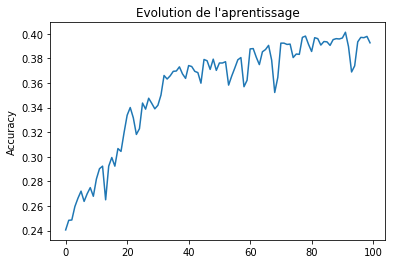

In [15]:
accuracy = list()
for i in range(100):
    perceptron_projet.train(training_2,10)
    accuracy.append(perceptron_projet.accuracy(predict_2))

plt.plot([i for i in range(100)],accuracy)
plt.title('Evolution de l\'aprentissage')
plt.ylabel('Accuracy')

## Place a la classification supervisé
Nous decidons donc de predire le genre d'un acteur a partir de:
* la note moyenne des films ou il a joue
* le nombre de films dans lesquels il a joue
* Le nombre de film joue pour chaque categorie

In [16]:
def categorie(liste_films):
    liste = [0]*20
    for i in liste_films:
        for genre in movies_set.loc[movies_set['title']==i]["genres"].values[0].split("|"):
            liste[categories.index(genre)]+=1
    return liste

In [17]:
def anneeMoyenne(listeDeFilm):
    moyenne=0
    for i in listeDeFilm:
        something=film_data.loc[film_data['original_title']==i]
        if len(something)>0:
            moyenne+=int(something['release_date'].values[0].split("-")[0])
    return moyenne/(len(listeDeFilm)*1.0)/1000

In [18]:
acteurs_lSet = ls.LabeledSet(4)
for i in dict_acteurs_moy.keys():
    les_films = getKeysByValue(acteurs_dans_film,i)
    if actors[i]==2:
        label = 1
    else:
        label=-1
    acteurs_lSet.addExample(np.array([dict_acteurs_moy[i],len(les_films)]+categorie(les_films)),[label])

In [19]:
train_acteurs,predict_acteurs = ls.split(0.6,acteurs_lSet)

In [20]:
clStoc = cl.ClassifierPerceptronKernelStochastique(len(kp.transform(acteurs_lSet.getX(0))),0.00001,kp)

Text(0, 0.5, 'Accuracy')

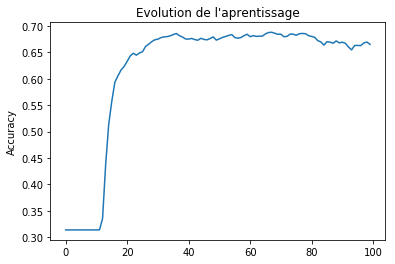

In [21]:
accuracy_acteurs = list()
for i in range(100):
    clStoc.train(train_acteurs,100)
    accuracy_acteurs.append(clStoc.accuracy(predict_acteurs))

plt.plot([i for i in range(100)],accuracy_acteurs)
plt.title('Evolution de l\'aprentissage')
plt.ylabel('Accuracy')

Nous nous sommes demande si la classification s'ameliore si l'on ajoute en plus l'annee de sortie du film.

In [22]:
film_data = pd.DataFrame(films_data)

In [23]:
def anneeMoyenne(listeDeFilm):
    moyenne=0
    for i in listeDeFilm:
        something=film_data.loc[film_data['original_title']==i]
        if len(something)>0:
            moyenne+=int(something['release_date'].values[0].split("-")[0])
    if len(listeDeFilm)>0:
        return moyenne/(len(listeDeFilm)*1.0)/1000
    return 0

In [24]:
acteurs_lSet_v2 = ls.LabeledSet(23)
for i in dict_acteurs_moy.keys():
    les_films = getKeysByValue(acteurs_dans_film,i)
    anneMoy = anneeMoyenne(les_films)
    if actors[i]==2:
        label = 1
    else:
        label=-1
    concat = [dict_acteurs_moy[i],len(les_films),anneMoy]+categorie(les_films)
    acteurs_lSet_v2.addExample(concat,label)


In [25]:
train_acteurs_v2,predict_acteurs_v2 = ls.split(0.6,acteurs_lSet_v2)

In [26]:
clStoc2 = cl.ClassifierPerceptronKernelStochastique(len(kp.transform(acteurs_lSet_v2.getX(0))),0.00001,kp)

Text(0, 0.5, 'Accuracy')

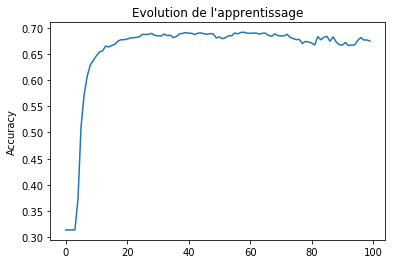

In [27]:
accuracy_acteurs = list()
for i in range(100):
    clStoc2.train(train_acteurs_v2,100)
    accuracy_acteurs.append(clStoc2.accuracy(predict_acteurs_v2))

plt.plot([i for i in range(100)],accuracy_acteurs)
plt.title('Evolution de l\'apprentissage')
plt.ylabel('Accuracy')

# Clustering
Nous nous sommes demander si l'on peut regrouper les utilisateurs qui ont notes les films.

Nous avons donc eu l'idee de prendre deux categories qui different un npeu: l'action et la romance. Puis nous avons regroupe pour chaque utilisateur la note moyenne des films d'action qu'il a donne et celle des films de romance.


In [28]:
genre_ratings = pd.DataFrame()

for genre in ["Action","Romance"]:
    genre_movies = movies_set[movies_set["genres"].str.contains(genre)]
    avg_rating_per_genre = ratings_set[[i in genre_movies['movieId'] for i in ratings_set['movieId']]].loc[:,['userId','rating']].groupby(['userId'])['rating'].mean().round(2)
    genre_ratings = pd.concat([genre_ratings,avg_rating_per_genre],axis=1)

In [29]:
genre_ratings.columns = ['avg_rating_action','avg_rating_romance']

In [30]:
genre_ratings = genre_ratings[np.isfinite(genre_ratings[genre_ratings.columns[0]])]
genre_ratings = genre_ratings[np.isfinite(genre_ratings[genre_ratings.columns[1]])]

Nous avons supprime les notes qui sont dans l'intervalle [2.5;3.5], que nous avons juge inutile pour notre etude.

In [31]:
genre_ratings = genre_ratings.drop(genre_ratings[(genre_ratings['avg_rating_action'] >= 2.5) \
                                                 & (genre_ratings['avg_rating_action'] <= 3.5)].index)

In [32]:
genre_ratings = genre_ratings.drop(genre_ratings[(genre_ratings['avg_rating_romance'] >= 2.5) \
                                                 & (genre_ratings['avg_rating_romance'] <= 3.5)].index)

In [35]:
genre_ratings = genre_ratings.reset_index()
genre_ratings = genre_ratings.drop('userId',axis=1)

Nous avons utilise en premier l'algorithme des KMeans que nous avons implante dans les tme 8 et 9.

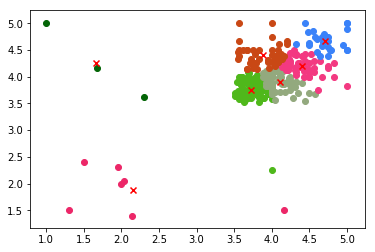

In [38]:
centroides_3, clustering_3 = km.kmoyennes(7,genre_ratings,0.05,1000)
km.affiche_resultat(genre_ratings,centroides_3,clustering_3)

Puis nous nous sommes dis pourquoi pas utiliser la bibliotheque sklearn, pour comparer nos resultats. 

Automatically created module for IPython interactive environment


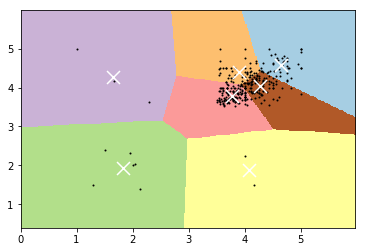

In [37]:
print(__doc__)

from time import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

data = np.array(genre_ratings)

n_samples, n_features = data.shape


# #############################################################################
# Visualize the results on PCA-reduced data


kmeans = KMeans(init='k-means++', n_clusters=7, n_init=10)
kmeans.fit(data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='w', zorder=10)


plt.show()